In [1]:
from __future__ import division
from util import countGC, ncf,TM_cal,binary_seqs,TranEmis
from util import *
import numpy as np
import scipy.io as sio
from scipy import stats
from mlxtend.plotting import plot_decision_regions
#import xgboost as xgb
from Bio.SeqUtils import MeltingTemp as mt
from Bio.Seq import Seq
import math
import pickle
from sklearn.preprocessing import MinMaxScaler,normalize
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
import copy
#from svmutil import *
import csv
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
path='/home/stephenvu/Downloads/712_code/'
from numpy.core.numeric import False_
from sklearn.metrics import f1_score, accuracy_score,plot_confusion_matrix,recall_score,precision_score,confusion_matrix
from copy import deepcopy
from deepsmnf import *
from NMFbase import *
from SMNF import *
import numpy as np
import pandas as pd
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.svm import SVC,NuSVC
from sklearn.decomposition import TruncatedSVD, PCA

import warnings
warnings.filterwarnings("ignore")
print(path)

/home/stephenvu/Downloads/712_code/


In [2]:
df_1= pd.read_excel(path+"/maindata.xlsx",sheet_name=0) #read mesc
df_2 = pd.read_excel(path+"/maindata.xlsx",sheet_name=1) #read hl60
df_3 = pd.read_excel(path+"/maindata.xlsx",sheet_name=2) #read hela_hart
df_4 = pd.read_excel(path+"/maindata.xlsx",sheet_name=3) #read HEK293T
df_5 = pd.read_excel(path+"/maindata.xlsx",sheet_name=4) #read HCT116
df=pd.concat([df_1,df_2,df_3,df_4,df_5]).reset_index().drop(columns=['index'])
# df=pd.concat([df_1,df_2]).reset_index().drop(columns=['index'])
df=df.drop_duplicates(subset=['seq','label'])
scaler = MinMaxScaler()
df

,seq,data,label
0,TTGGTGATGCTCACGAACGATGG,mesc,1
1,AGTGCAGCTGGATGCGCCCGTGG,mesc,1
2,CTGCAATGACGAGGGTGCCCTGG,mesc,1
3,AACCTGGACCCCGCTAACGACGG,mesc,1
4,TTACGAGTGTGCGGTGGACGTGG,mesc,1
...,...,...,...
17718,GCCTTCGCAGCCCGGACAGAGGG,hct116,1
17721,AGCACTCTTCACTGACCGGATGG,hct116,1
17751,GATCCTAATGAGAAGAGACCAGG,hct116,0
17753,GGAGGTTAATGCCATCAAGAAGG,hct116,1


# Get GC Count and GC Content: 

In [3]:
GC_count = [] 
GC_content = [] 
for seq in df['seq']:
    count,content = countGC(seq)
    GC_count.append(count)
    GC_content.append(content)


# Get Position-specific nucleotide binary features and Nucleotide composition features: 

In [4]:
psn_1 = [] 
nc_1 = [] 
for seq in df['seq']:
    nuc,pos = ncf(seq,1)
    psn_1.append(pos)
    nc_1.append(nuc)
nc_11=[i.flatten() for i in nc_1]
psn_2 = [] 
nc_2 = [] 
for seq in df['seq']:
    nuc2,pos2  = ncf(seq,2)
    psn_2.append(pos2)
    nc_2.append(nuc2)
nc_21=[i.flatten() for i in nc_2]

psn_3 = [] 
nc_3 = [] 
for seq in df['seq']:
    nuc3,pos3 = ncf(seq,3)
    psn_3.append(pos3)
    nc_3.append(nuc3)
nc_31=[i.flatten() for i in nc_3]



# Get Thermodynamic features

In [5]:
TMs =[]
for seq in df['seq']: 
    TM = TM_cal(seq)
    TMs.append(TM)
TMS=[i.flatten() for i in TMs]



# Get Binary Sequences: 

In [6]:
alpStat = [] 
for seq in df['seq']: 
    al = binary_seqs(seq)
    alpStat.append(al)
temp= [i.T for i in alpStat]
alpha = [i.flatten() for i in temp]


# Get Tr, ET - Pending

In [7]:
Trs = []
ETs = []
for seq in alpStat: 
    tr,et = TranEmis(seq.T,1)
    Trs.append(tr)
    ETs.append(et)

# Data Integration

In [8]:
df['GCcount']=GC_count
df['GC_content']=GC_content
d=pd.get_dummies(df['data'])
# d2=pd.get_dummies(df['score'],prefix="label")
d3=pd.DataFrame(nc_11).add_prefix('nc1')
d4=pd.DataFrame(psn_1).add_prefix('psn1')
d5=pd.DataFrame(nc_21).add_prefix('nc2')
d6=pd.DataFrame(psn_2).add_prefix('psn2')
d7=pd.DataFrame(nc_31).add_prefix('nc3')
d8=pd.DataFrame(psn_3).add_prefix('psn3')
d9=pd.DataFrame(TMS).add_prefix('tms')
d10=pd.DataFrame(alpha).add_prefix('alpStat')
df_concat = pd.concat([df,d,d3,d4,d5,d6,d7,d8,d9,d10],axis=1)
data = df_concat.drop_duplicates(subset=['seq','label'])
data = data.fillna(1)
data.to_hdf('data.h5',key='data')
print("The processed dataset will have {0} guide RNA and {1} features".format(data.shape[0],data.shape[1]))

The processed dataset will have 13884 guide RNA and 1909 features


# Data Split 

In [2]:
# Resampling 
data = pd.read_hdf('data.h5')
count_class_1, count_class_0 = data.label.value_counts()
df_class_0 = data[data['label'] == 0]
df_class_1 = data[data['label'] == 1]
df_class_1_under = df_class_1.sample(count_class_0)
df_test_under = pd.concat([df_class_1_under, df_class_0], axis=0)
df_test_under = df_test_under.sample(frac=1).reset_index()
X = df_test_under.drop(columns=['seq','label','data']).values
X = normalize(X)

Y = df_test_under[['label']].values


In [3]:
df_test_under[['label']].value_counts()

label
0.0      5038
1.0      5038
dtype: int64

In [4]:
def gradientbars(bars):
    grad = np.atleast_2d(np.linspace(0,1,256)).T
    ax = bars[0].axes
    lim = ax.get_xlim()+ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x,y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        ax.imshow(grad, extent=[x,x+w,y,y+h], aspect="auto", zorder=0)
    ax.axis(lim)

# Model Training

In [5]:
layers = [100, 50, 2] 
print(X.shape)


(10076, 1907)
5038
8846


In [6]:
matrix = SNMF(X, Y, layers=layers, k=3, option='b')
matrix.compute_factors(random_init=True)
matrix.collector.drop(columns=['index'], inplace=True)
matrix_copy = deepcopy(matrix)
deepMatrix = Deep(matrix_copy, alpha=100,  iteration=100, lam1=1, lam2=10, lamz=10, normH=True, normH2=True,normZ=True, othorZ=False, othorH=False)

matrix_ = deepMatrix.run_main()
a = matrix_.collector['H'][2].T*10000
b = matrix_.collector['H2'][2].T*10000
pd.DataFrame(b).to_hdf('H2.h5',key='H2')
# cs = KMeans(n_clusters=2,  random_state=42).fit(a)
# cs3 = KMeans(n_clusters=2,  random_state=42).fit(b)
# #curr_accuracy = accuracy_score(matrix_.Y[1], cs.labels_)
# print("Training:{}".format(accuracy_score(matrix_.Y[1], cs.labels_)))
# print("Testing:{}".format(accuracy_score(matrix_.Y2[1], cs3.labels_)))
# unique, counts = np.unique(cs.labels_, return_counts=True)
# unique1, counts1 = np.unique(cs3.labels_, return_counts=True)
# print(dict(zip(unique, counts)))
# print(dict(zip(unique1, counts1)))



g shape: (7053, 1908)
converging
Error:  22299.589192645475
Difference: -9324.40569348232
Difference: -9324.40569348232
Converged at the 2th iteration


In [14]:

clf = KMeans(n_clusters=2)
y_true = matrix_.Y[0].flatten().flatten()
clf.fit(a,y_true)

y_pred = clf.predict(a)
accuracy_score(y_true,y_pred)

0.0

In [2]:
h2 = pd.read_hdf('H2.h5')

# Comparison SVD, PCA and DSNMF

## a. Statistical Analysis

In [16]:
methods = ['p','s']
comparison = []
for i in methods: 
    comparison.append(evaluate_dimension(i,a,b,matrix))



NameError: name 'confusion_matrix' is not defined

## b. Visualization

In [ ]:
result1=pd.DataFrame(comparison,columns=['class_error','precision','recall','accuracy','f1','nmi'])
result1['Decomposition Method'] = col

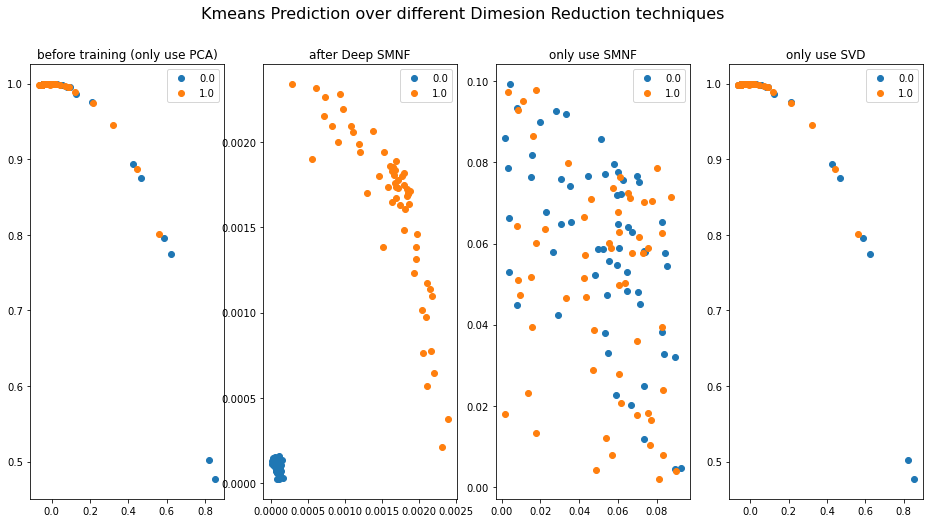

In [ ]:
visualize_scatter(matrix,matrix_)

In [ ]:
result1

,class_error,precision,recall,accuracy,f1,nmi,Decomposition Method
0,0.496975,0.500000,0.045217,0.503025,0.082935,0.000002,SVD
1,0.496975,0.500000,0.045217,0.503025,0.082935,0.000002,PCA
2,0.332115,0.865612,0.751234,0.811234,0.831412,0.000443,DeepSNMF


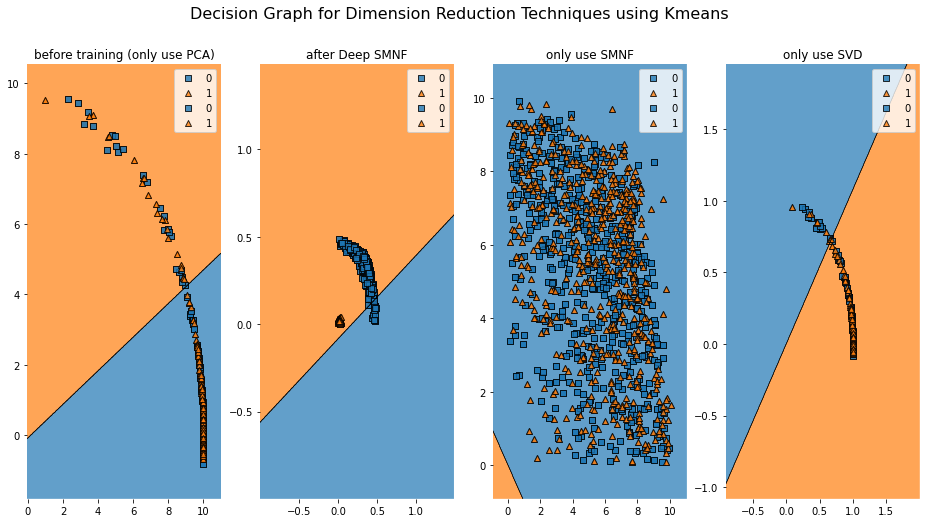

In [ ]:
visualize_decision(matrix,matrix_)

In [28]:
if __name__ == '__main__':

    train_path = "/home/stephenvu/Downloads/CNN-SVR/data/training_example.csv"
    test_path = "/home/stephenvu/Downloads/CNN-SVR/data/testing_example.csv"

    # Load data
    seq_train, seq_test, epi_train, epi_test, y_train, y_test = load_data(train_path, test_path)

    merged, model = build_model()

    new_model = Model(model.inputs, outputs=[merged])
    x_train = new_model.predict([seq_train, epi_train])
    x_test = new_model.predict([seq_test, epi_test])

    x_train, x_test = np.array(x_train), np.array(x_test)

    # Select important features from initial CNN features
    selected_cnn_fea_cols = [17, 26, 9, 19, 30, 6, 12, 39, 36, 21, 22, 3, 25]
    x_train = x_train[:, selected_cnn_fea_cols]
    x_test = x_test[:, selected_cnn_fea_cols]

    y_train = np.array(y_train).ravel()
    y_test = np.array(y_test).ravel()

    clf = SVC(kernel="rbf", gamma=0.12, C=1.7)
    
    # Fit the SVR model according to the given training data
    clf.fit(matrix.X.T, matrix.Y.T.flatten())

    # Perform regression on samples in x_test
    y_pred = clf.predict(matrix.X2.T)
    print(y_pred)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.

In [29]:
print(accuracy_score(matrix.Y2.T.flatten(),y_pred))

0.48893360160965793


In [30]:
y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.